In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/faces-of-friends/20230923_161249.jpg


In [2]:
# !pip install ultralytics
# !pip install supervision
# !pip install --upgrade supervision

In [3]:
# # load libraries
# from huggingface_hub import hf_hub_download
# from ultralytics import YOLO
# from supervision import Detections
# from PIL import Image

# # download model
# model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")

# # load model
# model = YOLO(model_path)

# # inference
# image_path = "/kaggle/input/faces-of-friends/20230923_161249.jpg"
# output = model(Image.open(image_path))
# results = Detections.from_ultralytics(output[0])



0: 288x640 2 FACEs, 99.0ms
Speed: 2.4ms preprocess, 99.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


In [4]:
results

Detections(xyxy=array([[     2676.5,      102.19,      2939.6,      478.76],
       [     1472.5,      294.16,      1688.9,      503.24]], dtype=float32), mask=None, confidence=array([    0.47523,     0.34062], dtype=float32), class_id=array([0, 0]), tracker_id=None, data={'class_name': array(['FACE', 'FACE'], dtype='<U4')}, metadata={})


0: 288x640 2 FACEs, 76.9ms
Speed: 2.3ms preprocess, 76.9ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


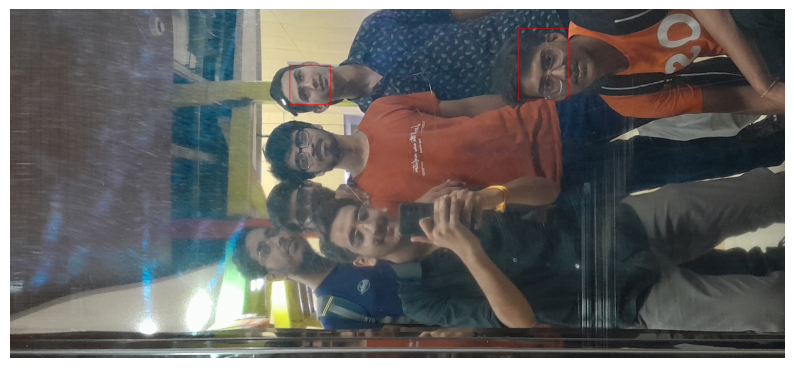

In [5]:
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Download model
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")

# Load model
model = YOLO(model_path)

# Load image
image_path = "/kaggle/input/faces-of-friends/20230923_161249.jpg"
image = Image.open(image_path)

# Perform inference
output = model(image)
results = Detections.from_ultralytics(output[0])

# Draw bounding boxes on the image
draw = ImageDraw.Draw(image)
for box in results.xyxy:  # Assuming results.xyxy contains the bounding boxes
    x1, y1, x2, y2 = box[:4]  # Extract the coordinates
    draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [8]:
# !pip install dlib

In [36]:
import cv2
import dlib
import numpy as np
from skimage.feature import local_binary_pattern
from matplotlib import pyplot as plt
import json

# Load the image
image_path = "/kaggle/input/raj-dt/WhatsApp Image 2025-01-18 at 18.33.44_df0c4d7f.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Load Dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/kaggle/input/shape-pred2/shape_predictor_68_face_landmarks.dat")

# Initialize a list to store results for each face
results = []

# Detect faces in the image
faces = detector(gray)

# Iterate over each detected face
for face in faces:
    # Get the landmarks
    landmarks = predictor(gray, face)
    landmarks_array = np.array([(p.x, p.y) for p in landmarks.parts()])

    # Extract the face region
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    face_region = image[y:y+h, x:x+w]

    # Calculate average skin tone in HSV
    hsv_face = cv2.cvtColor(face_region, cv2.COLOR_BGR2HSV)
    avg_skin_tone = cv2.mean(hsv_face)[:3]

    # Analyze skin texture using LBP
    lbp = local_binary_pattern(cv2.cvtColor(face_region, cv2.COLOR_BGR2GRAY), P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 59), density=True)

    # Detect dark circles
    left_eye = landmarks_array[36:42]
    right_eye = landmarks_array[42:48]
    under_eye_region = image[min(left_eye[:,1]):max(left_eye[:,1]), min(left_eye[:,0]):max(right_eye[:,0])]
    avg_under_eye_intensity = np.mean(cv2.cvtColor(under_eye_region, cv2.COLOR_BGR2GRAY))

    # Detect spots using simple thresholding
    gray_face = cv2.cvtColor(face_region, cv2.COLOR_BGR2GRAY)
    _, spots = cv2.threshold(gray_face, 120, 255, cv2.THRESH_BINARY_INV)
    num_spots = cv2.countNonZero(spots)

    # Store the results in a dictionary
    face_result = {
        "average_skin_tone_hsv": {
            "hue": avg_skin_tone[0],
            "saturation": avg_skin_tone[1],
            "value": avg_skin_tone[2]
        },
        "lbp_histogram": lbp_hist.tolist(),
        "average_under_eye_intensity": avg_under_eye_intensity,
        "number_of_spots": num_spots
    }

    # Append the result for this face to the list
    results.append(face_result)

# Convert the results to JSON format
# results_json = json.dumps(results, indent=4)
print(results)

# # Display the image with landmarks
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

[{'average_skin_tone_hsv': {'hue': 28.57534920469283, 'saturation': 68.50143855935362, 'value': 154.10864477273742}, 'lbp_histogram': [0.015607996302976998, 0.03705967412531119, 0.03093275294047495, 0.12724914655416586, 0.34643192558250474, 0.22784394985167186, 0.07075028696650318, 0.04774824465944157, 0.046317138981231645, 0.05005888403571801, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'average_under_eye_intensity': 102.98486412108703, 'number_of_spots': 30597}]


In [38]:
import google.generativeai as genai

# Configure the API with your API key
genai.configure(api_key="api_key")

# Initialize the generative model
model = genai.GenerativeModel("gemini-1.5-flash")

# Prepare the additional context and data
patient_info = {
    "age": 30,
    "gender": "female",
    "lifestyle": "active",
    "diet": "vegetarian"
}

data = results

# Create a detailed prompt incorporating the additional context
prompt = (
    "Based on the following facial analysis data, provide insights into potential health conditions or recommendations:\n\n"
    f"Average Skin Tone (HSV):\n"
    f"Hue: {data[0]['average_skin_tone_hsv']['hue']}\n"
    f"Saturation: {data[0]['average_skin_tone_hsv']['saturation']}\n"
    f"Value: {data[0]['average_skin_tone_hsv']['value']}\n\n"
    f"LBP Histogram: {data[0]['lbp_histogram']}\n\n"
    f"Average Under-Eye Intensity: {data[0]['average_under_eye_intensity']}\n"
    # f"Number of Spots: {data[0]['number_of_spots']}\n"
)

# Generate content using the model
response = model.generate_content(prompt)

# Print the response
print(response.text)

The provided data offers limited information for definitive health condition diagnoses.  However, we can make some tentative observations and recommendations:

**Skin Tone Analysis (HSV):**

* **Hue (28.57):** This indicates a skin tone in the yellowish-to-light-tan range. This is a general observation and not indicative of any specific health issue.
* **Saturation (68.50):**  A relatively high saturation suggests a relatively vibrant skin color. Again, this is not inherently indicative of a health problem.
* **Value (154.11):** This represents the brightness or lightness.  A value around 154 suggests a relatively light skin tone.

**LBP Histogram:** This histogram represents Local Binary Patterns, a texture analysis technique.  The high values clustered around the middle bins (indices 4-6) suggest relatively smooth skin texture. The many zero values towards the end indicate a lack of complex or highly textured features. Without knowing the specific LBP parameter settings (radius, neig